In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner

In [2]:
from scipy import integrate

In [3]:
def H_z(z,H0,Om,Ode,w0,w1):
    Ode=1-Om
    # quad only accepts scalars, so need to use a list comprehension to run through the whole array of z
    b= lambda zz : (1+w0+w1*(zz/(1+zz)))/(1+zz)
    b1=[integrate.quadrature(b,0,zi) for zi in z]
    # Returns a list, so we convert to a numpy array
    B1=np.array(b1)
    B2=B1.reshape(-1, 1)
    x=(Om*(1+z)**3) + (1-Om)*np.exp(3*B1[:,0])
    x1=np.array(x)
    x2=x1.reshape(1,-1)
    Hzz=H0*np.sqrt(x)
    return Hzz

In [4]:
#Define  random redshifts
zs= np.linspace(0.01, 3., num=1000)

In [5]:
#From Planck observations for CPL mode
O_m= 0.3029
O_de= 1-O_m
w_0= -0.9414
w_1= -0.4303
H_0= 68.5265

In [6]:
#Hubble comoving parameter
Hz=H_z(zs,H_0,O_m,O_de,w_0,w_1)/(1+zs)

In [7]:
Hz.shape

(1000,)

In [8]:
print Hz

[68.19837046 68.10163166 68.00556674 67.91017376 67.8154507  67.72139556
 67.62800629 67.53528083 67.44321707 67.35181291 67.26106622 67.17097482
 67.08153655 66.9927492  66.90461057 66.8171184  66.73027045 66.64406446
 66.55849812 66.47356914 66.38927521 66.30561399 66.22258313 66.14018028
 66.05840306 65.97724909 65.89671599 65.81680133 65.7375027  65.65881769
 65.58074384 65.50327872 65.42641988 65.35016484 65.27451115 65.19945633
 65.12499789 65.05113335 64.9778602  64.90517596 64.83307811 64.76156414
 64.69063154 64.6202778  64.55050038 64.48129677 64.41266443 64.34460083
 64.27710345 64.21016974 64.14379717 64.07798321 64.01272531 63.94802093
 63.88386753 63.82026257 63.75720352 63.69468783 63.63271296 63.57127638
 63.51037554 63.45000792 63.39017097 63.33086216 63.27207896 63.21381885
 63.1560793  63.09885778 63.04215177 62.98595876 62.93027623 62.87510167
 62.82043257 62.76626643 62.71260075 62.65943303 62.60676078 62.55458151
 62.50289274 62.451692   62.4009768  62.35074468 62

In [9]:
#random error for Hz
error_sigma = 0.5
e1 = np.random.normal(0., error_sigma, 1000)

In [10]:
H_zz= Hz + e1

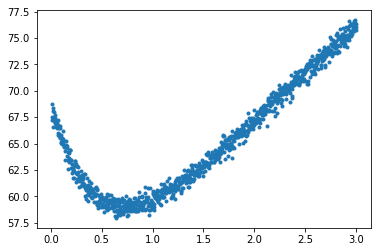

In [11]:
plt.plot(zs,H_zz, '.')

In [12]:
from astropy.cosmology import w0waCDM

In [13]:
def Hz1(Z1,H01,Om1,Ode1,w01,wa1):
    cosmo = w0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,Ode0=Ode1,w0=w01,wa=wa1)
    E=cosmo.efunc(Z1)
    HZ1=H01*E
    return HZ1

In [15]:
d = {'redshift': zs, 'Hubble_param': H_zz,'Hz_err':e1}

In [16]:
#create a panda dataframe in order to sort the values
df = pd.DataFrame(data=d)

In [17]:
dat=np.sort(df.T, axis=0)
z1 = df.redshift
Hzz1 = df.Hubble_param
e2 =df.Hz_err

In [21]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.0,True,50.,100.),
           ('Ode1',0.7,True,0.,2.),
           ('w01',-1.0,True,-2.,2.),
           ('wa1',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (Hz1(z1,v['H01'],v['Om1'],v['Ode1'],v['w01'],v['wa1'])-Hzz1)/error_sigma

In [22]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1553
    # data points      = 1000
    # variables        = 5
    chi-square         = 1177.72408
    reduced chi-square = 1.18364229
    Akaike info crit   = 173.583830
    Bayesian info crit = 198.122606
[[Variables]]
    Om1:   2.3826e-07 (init = 0.3)
    H01:   69.0689457 (init = 70)
    Ode1:  0.99248318 (init = 0.7)
    w01:  -1.43033582 (init = -1)
    wa1:   0.99603279 (init = -0.1)


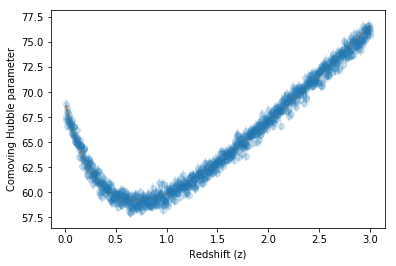

In [23]:
s = (z1.sort_values()).index
#plt.errorbar(z1[s],Hzz1[s],yerr=e2[s],fmt='o',alpha=0.4)
plt.errorbar(z1[s],Hzz1[s],yerr=error_sigma,fmt='o',alpha=0.2)
bestOm1 = mi.params.valuesdict()['Om1']
bestH01 = mi.params.valuesdict()['H01']
bestOde1= mi.params.valuesdict()['Ode1']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(z1[s],Hz1(z1[s],bestH01,bestOm1,bestOde1,bestw01,bestwa1))
plt.xlabel('Redshift (z)')
plt.ylabel('Comoving Hubble parameter')
lmfit.report_fit(mi)

In [24]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=2500,thin=1,
                         params=p, is_weighted=True)

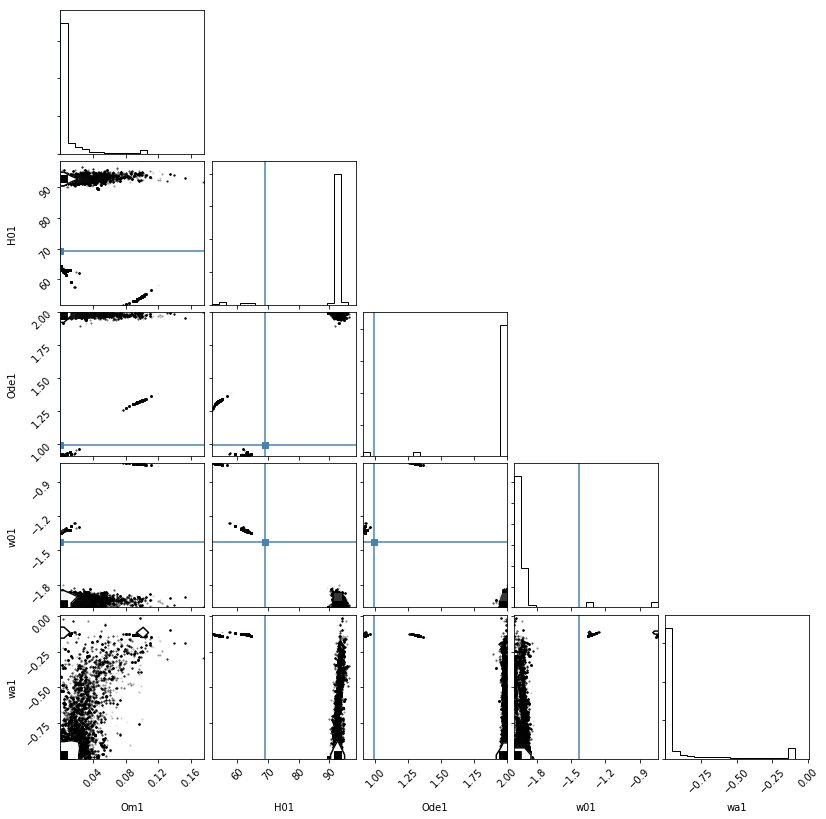

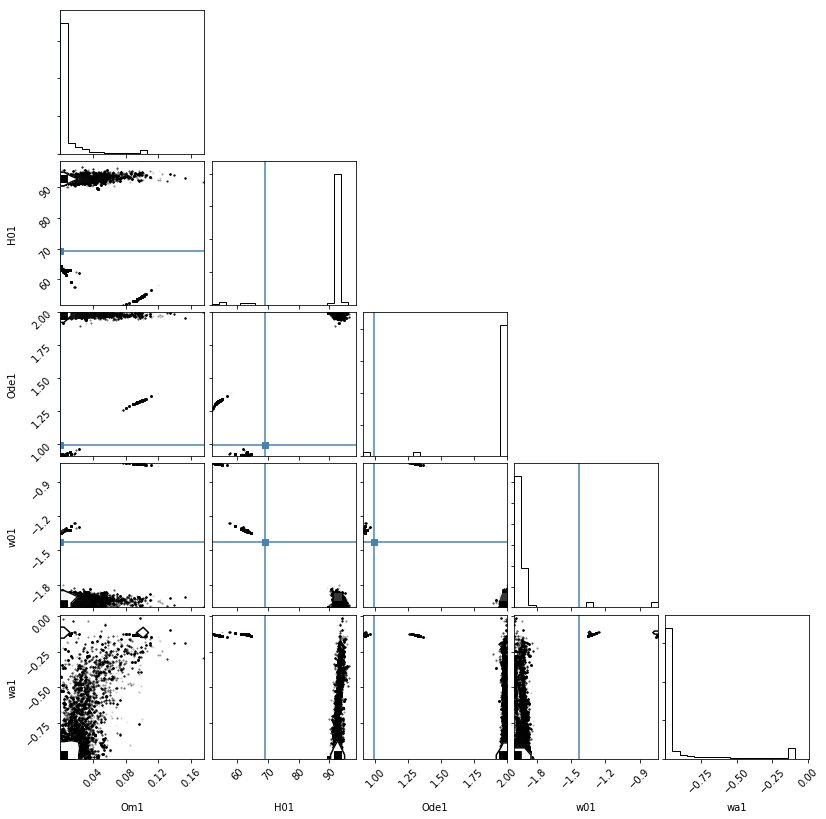

In [25]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))